---
title: "Torre de vigilancia confiabilidad"
subtitle: "DANTOTSU"
author: "Departamento Confiabilidad"
date: today
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from IPython.display import Markdown
import dagster as dg
import polars as pl
from kdags.definitions import *
from kdags.readr import *
from datetime import datetime, timedelta
from theme_komatsu import *

context = dg.build_asset_context()

In [2]:
result = kdefs.get_job_def("warranties_job").execute_in_process(raise_on_error=False)

2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - RUN_START - Started execution of run for "warranties_job".
2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - ENGINE_EVENT - Executing steps in process (pid: 34664)
2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - LOGS_CAPTURED - Started capturing logs in process (pid: 34664).
2025-06-09 16:39:40 -0400 - dagster - DEBUG - warranties_job - 81472b5b-92e8-4916-b870-7f249c618d45 - 34664 - component_ch

In [33]:
w_df = result.asset_value("mutate_warranties")
Markdown(
    w_df.select(
        [
            "equipment_name",
            "component_name",
            "position_name",
            "changeout_date",
            "component_hours",
            "warranty_hours",
            "component_serial",
            "warranty_type",
            "warranty_claim_status",
            "warranty_resolution",
        ]
    )
    .to_pandas()
    .to_markdown(index=False)
)
# w_df

| equipment_name   | component_name           | position_name   | changeout_date      |   component_hours |   warranty_hours | component_serial   | warranty_type   | warranty_claim_status   | warranty_resolution   |
|:-----------------|:-------------------------|:----------------|:--------------------|------------------:|-----------------:|:-------------------|:----------------|:------------------------|:----------------------|
| TK881            | blower_parrilla          | izquierdo       | 2025-05-17 00:00:00 |              6384 |             3000 | EE14050656         | political       | without_warranty        |                       |
| TK871            | conjunto_maza_suspension | izquierdo       | 2025-05-17 00:00:00 |              3638 |             1000 | 239                | political       | unclaimed               |                       |
| TK880            | blower_parrilla          | derecho         | 2025-05-07 00:00:00 |              1081 |             3000 | EE13080715         | normal          | without_warranty        |                       |
| TK879            | cilindro_levante         | derecho         | 2025-05-05 00:00:00 |               220 |             1000 | 223                | normal          | claimed                 | without_warranty      |
| TK851            | blower_parrilla          | izquierdo       | 2025-05-01 00:00:00 |              2560 |             3000 | EN12020055         | normal          | claimed                 | political_warranty    |
| TK871            | conjunto_maza_suspension | derecho         | 2025-04-24 00:00:00 |              3251 |             1000 | 201-1              | political       | claimed                 | without_warranty      |
| TK320            | cilindro_direccion       | derecho         | 2025-04-24 00:00:00 |              1469 |             1000 | EMVC225            | political       | claimed                 | without_warranty      |
| TK857            | blower_parrilla          | derecho         | 2025-04-03 00:00:00 |              3256 |             3000 | EE19080474         | political       | claimed                 | workshop_warranty     |
| TK863            | blower_parrilla          | derecho         | 2025-03-29 00:00:00 |              4167 |             3000 | EE04040113         | political       | without_warranty        |                       |
| TK880            | blower_parrilla          | derecho         | 2025-03-09 00:00:00 |              3816 |             3000 | EE13060475         | political       | claimed                 | without_warranty      |
| TK863            | conjunto_maza_suspension | izquierdo       | 2025-03-03 00:00:00 |              2691 |             1000 | 202                | political       | unclaimed               |                       |
| TK879            | motor_traccion           | derecho         | 2025-03-02 00:00:00 |              5893 |             3000 | W12010011          | political       | unclaimed               |                       |
| TK874            | modulo_potencia          | unico           | 2025-02-15 00:00:00 |                 0 |             3000 | EE13070408         | normal          | claimed                 | workshop_warranty     |
| TK879            | blower_parrilla          | derecho         | 2025-02-06 00:00:00 |              3916 |             3000 | EE10040299         | political       | claimed                 |                       |
| TK289            | blower_parrilla          | izquierdo       | 2025-01-09 00:00:00 |              4542 |             3000 | EE21060597         | political       | unclaimed               |                       |

In [29]:
def prepare_monthly_data(
    df,
    date_column="changeout_date",
    group_column="warranty_claim_status",
    count_label="warranty_count",
    additional_aggs=None,
    filter_expr=None,
):
    """
    Prepare data for monthly analysis with flexible grouping

    Args:
        df: Polars DataFrame with raw data
        date_column: Name of the date column to use for monthly grouping
        group_column: Column name to group by (e.g., 'warranty_claim_status', 'warranty_type')
        count_label: Label for the count column in output
        additional_aggs: List of additional aggregations as tuples (column, agg_func, alias)
                        e.g., [("warranty_hours", pl.mean, "avg_warranty_hours")]
        filter_expr: Polars expression to filter data before aggregation
                     e.g., pl.col("warranty_claim_status") != "No_Warranty"

    Returns:
        Polars DataFrame ready for plotting with columns:
        - month_date: First day of each month
        - month_label: Formatted month label (e.g., "Jan 2024")
        - [group_column]: The grouping column values
        - [count_label]: Count of records
        - Any additional aggregated columns
    """
    # Apply filter if provided
    if filter_expr is not None:
        df = df.filter(filter_expr)

    # Build aggregation expressions
    agg_exprs = [pl.count().alias(count_label)]

    # Add any additional aggregations
    if additional_aggs:
        for col_name, agg_func, alias in additional_aggs:
            agg_exprs.append(agg_func(col_name).alias(alias))

    # Perform the aggregation
    monthly_data = (
        df.with_columns(
            [
                pl.col(date_column).dt.year().alias("year"),
                pl.col(date_column).dt.month().alias("month"),
                # Create a proper date for the first day of each month
                pl.date(
                    pl.col(date_column).dt.year(), pl.col(date_column).dt.month(), 1
                ).alias("month_date"),
                # Create month-year label for x-axis
                pl.col(date_column).dt.strftime("%b %Y").alias("month_label"),
            ]
        )
        .group_by(["month_date", "month_label", group_column])
        .agg(agg_exprs)
        .sort(["month_date", group_column])
    )
    return monthly_data


def create_monthly_bar_plot(
    df_aggregated,
    group_column,
    value_column="warranty_count",
    title="Monthly Analysis",
    subtitle="",
    x_label="Month",
    y_label="Count",
    legend_title=None,
    plot_type="stacked",
    color_palette=None,
    figure_size=(14, 7),
    show_all_months=True,
    bar_width=20,
    title_suffix="",
):
    """
    Create a flexible monthly bar plot with Komatsu theme

    Args:
        df_aggregated: Polars DataFrame with aggregated monthly data
                      Must contain 'month_date' column and the specified group_column
        group_column: Column name to use for grouping/coloring bars
        value_column: Column name containing the values to plot (default: 'warranty_count')
        title: Main plot title
        subtitle: Plot subtitle
        x_label: X-axis label
        y_label: Y-axis label
        legend_title: Legend title (if None, uses group_column)
        plot_type: "stacked" or "dodged" for bar arrangement
        color_palette: List of colors or dict mapping group values to colors
                      If None, uses COMPONENT_COLORS
        figure_size: Tuple of (width, height) in inches
        show_all_months: If True, shows all months on x-axis (no skipping)
        bar_width: Width of bars in days (for datetime x-axis)
        title_suffix: Additional text to append to title

    Returns:
        plotnine plot object
    """
    # Get unique groups for color assignment
    unique_groups = df_aggregated[group_column].unique().sort()

    # Set up color mapping
    if color_palette is None:
        color_palette = COMPONENT_COLORS

    if isinstance(color_palette, dict):
        color_map = color_palette
    else:
        color_map = {
            group: color_palette[i % len(color_palette)]
            for i, group in enumerate(unique_groups)
        }

    # Convert to pandas for plotnine
    plot_df = df_aggregated.to_pandas()

    # Sort by date to ensure correct order
    plot_df = plot_df.sort_values("month_date")

    # Set legend title
    if legend_title is None:
        legend_title = group_column.replace("_", " ").title()

    # Create the base plot
    plot = (
        p9.ggplot(plot_df, p9.aes(x="month_date", y=value_column, fill=group_column))
        + p9.scale_fill_manual(values=color_map, name=legend_title)
        + p9.labs(
            title=f"{title}{title_suffix}",
            subtitle=(
                subtitle if subtitle else f"Distribution by {legend_title.lower()}"
            ),
            x=x_label,
            y=y_label,
            caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
        )
        + theme_komatsu(figure_size=figure_size)
    )

    # Configure x-axis to show all months
    if show_all_months:
        # Get the date range
        min_date = plot_df["month_date"].min()
        max_date = plot_df["month_date"].max()

        # Calculate appropriate date breaks
        date_range_days = (max_date - min_date).days

        if date_range_days <= 365:  # Less than a year
            date_breaks = "1 month"
            date_labels = "%b\n%Y"
        elif date_range_days <= 730:  # Less than 2 years
            date_breaks = "1 month"
            date_labels = "%b"
        else:  # More than 2 years
            date_breaks = "2 months"
            date_labels = "%b\n%Y"
    else:
        date_breaks = "2 months"
        date_labels = "%b\n%Y"

    plot = plot + p9.scale_x_datetime(date_labels=date_labels, date_breaks=date_breaks)

    # Add bars based on plot type
    if plot_type == "stacked":
        plot = plot + p9.geom_col(position="stack", width=bar_width)
    else:
        plot = plot + p9.geom_col(position="dodge", width=bar_width)

    # Rotate x-axis labels if showing all months
    if show_all_months and date_range_days > 365:
        plot = plot + p9.theme(
            axis_text_x=p9.element_text(rotation=45, ha="right", size=9)
        )

    return plot

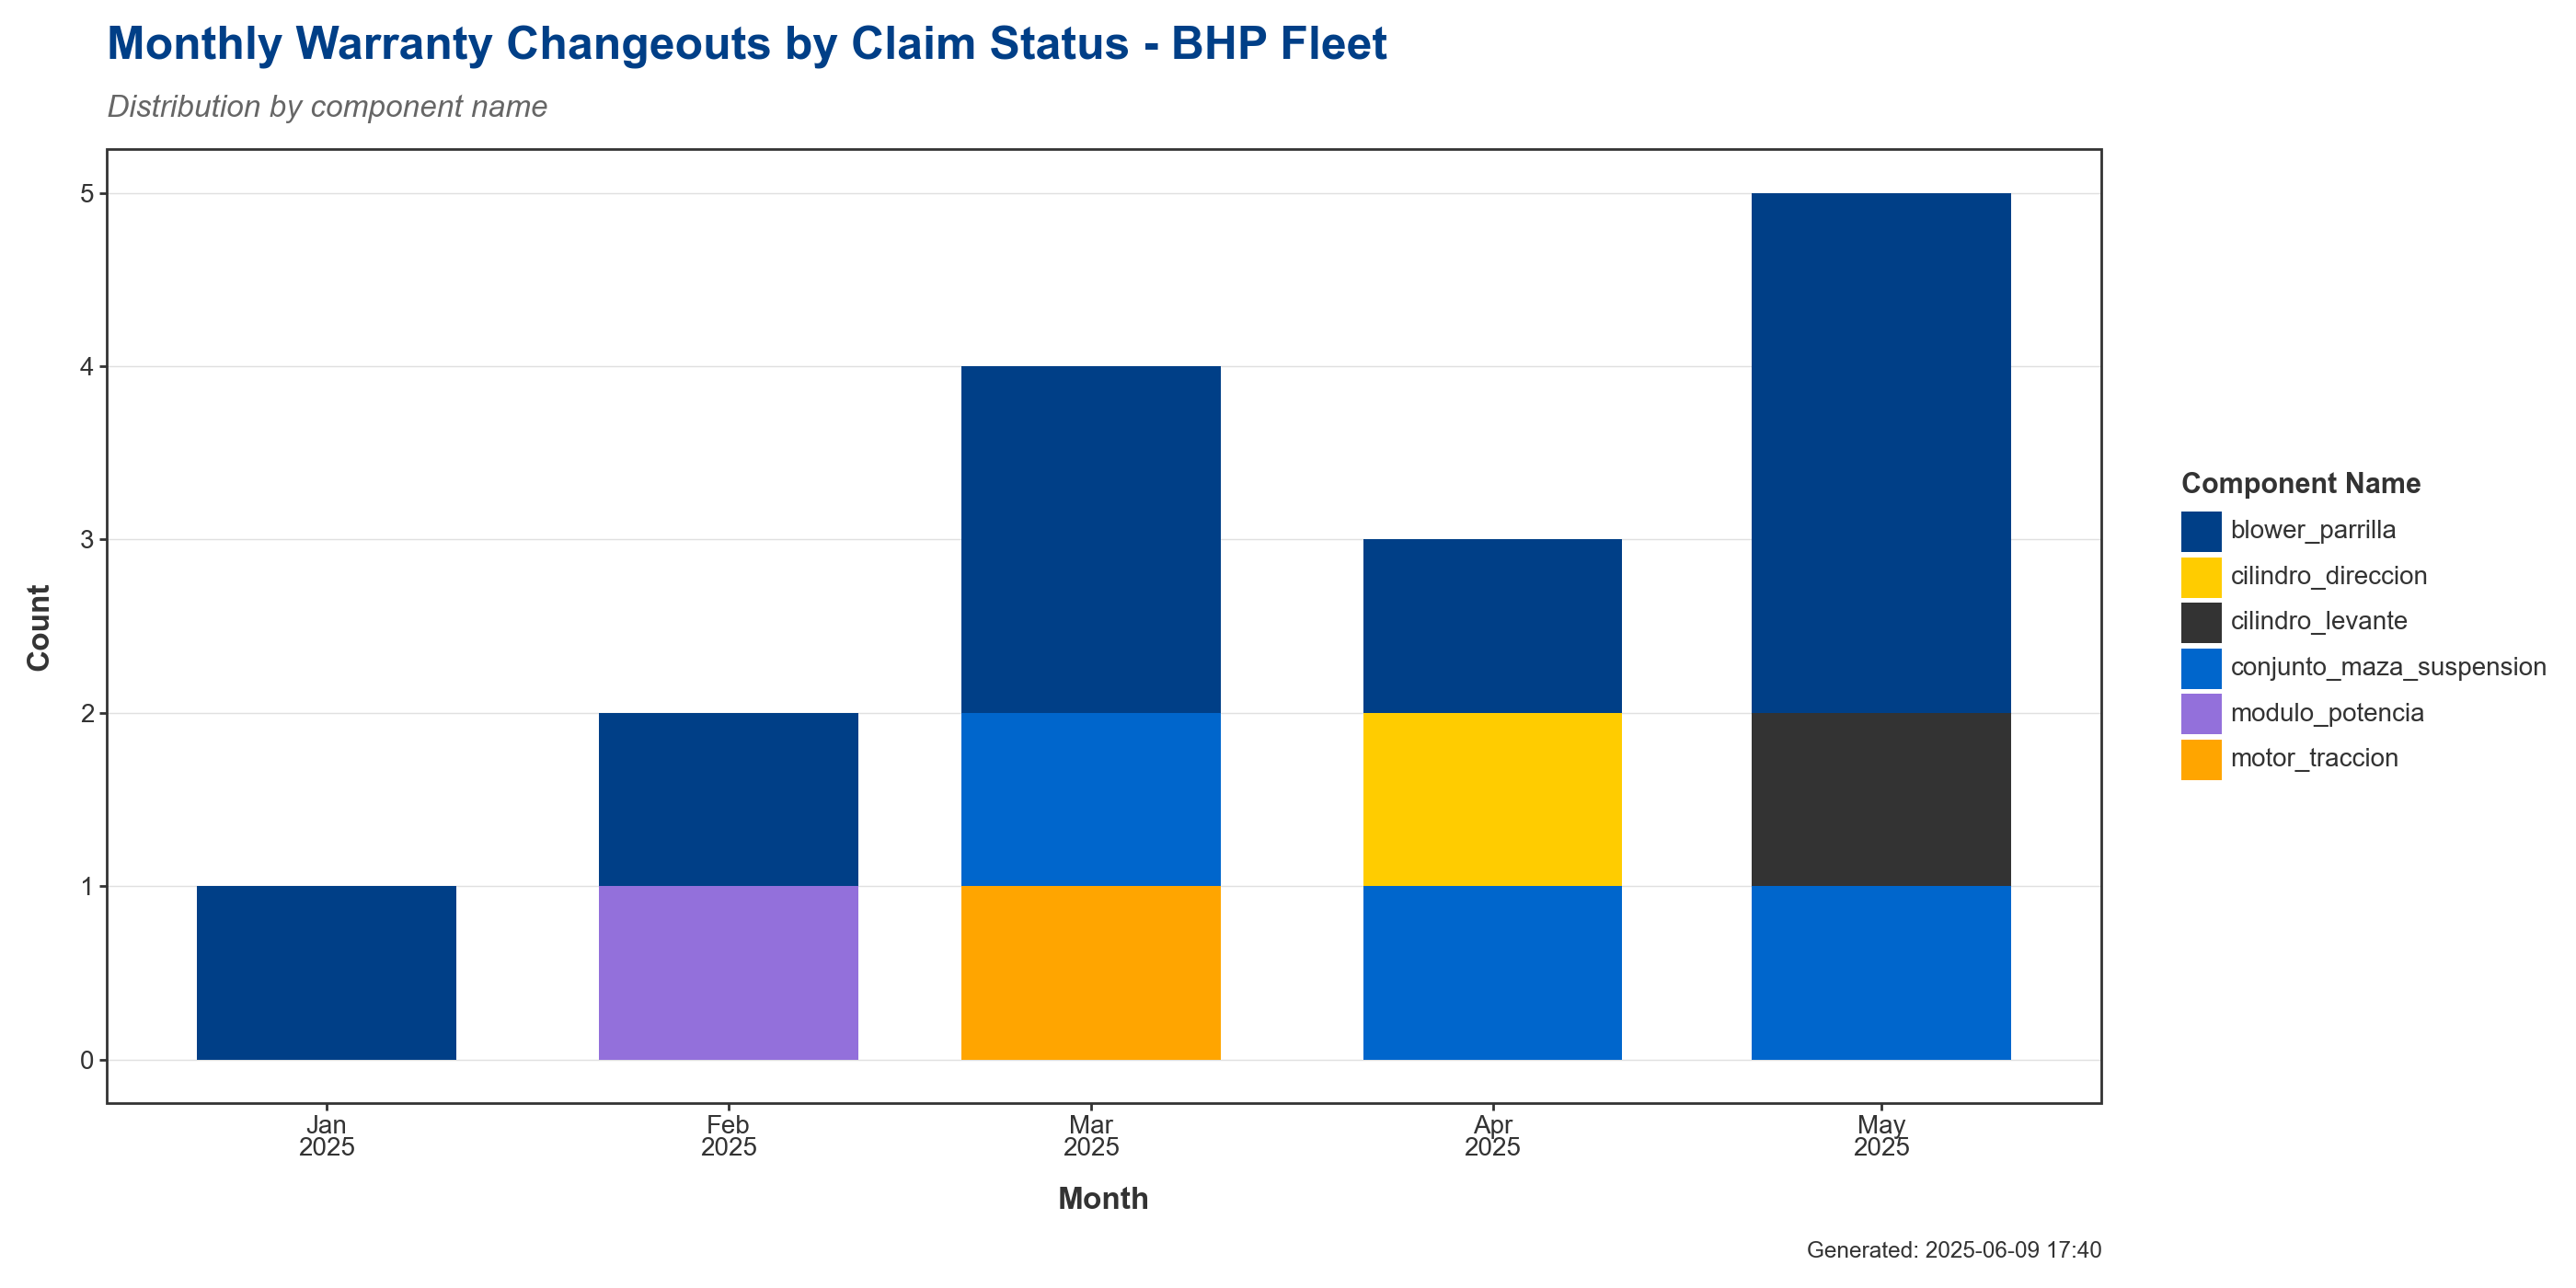

In [31]:
# Method 2: Use the main function with custom parameters
plot_data = prepare_monthly_data(
    w_df,
    date_column="changeout_date",
    group_column="component_name",
    count_label="warranty_count",
)
# Then create your plot
plot = create_monthly_bar_plot(
    df_aggregated=plot_data,
    group_column="component_name",
    title="Monthly Warranty Changeouts by Claim Status",
    title_suffix=" - BHP Fleet",
    show_all_months=True,
)
plot

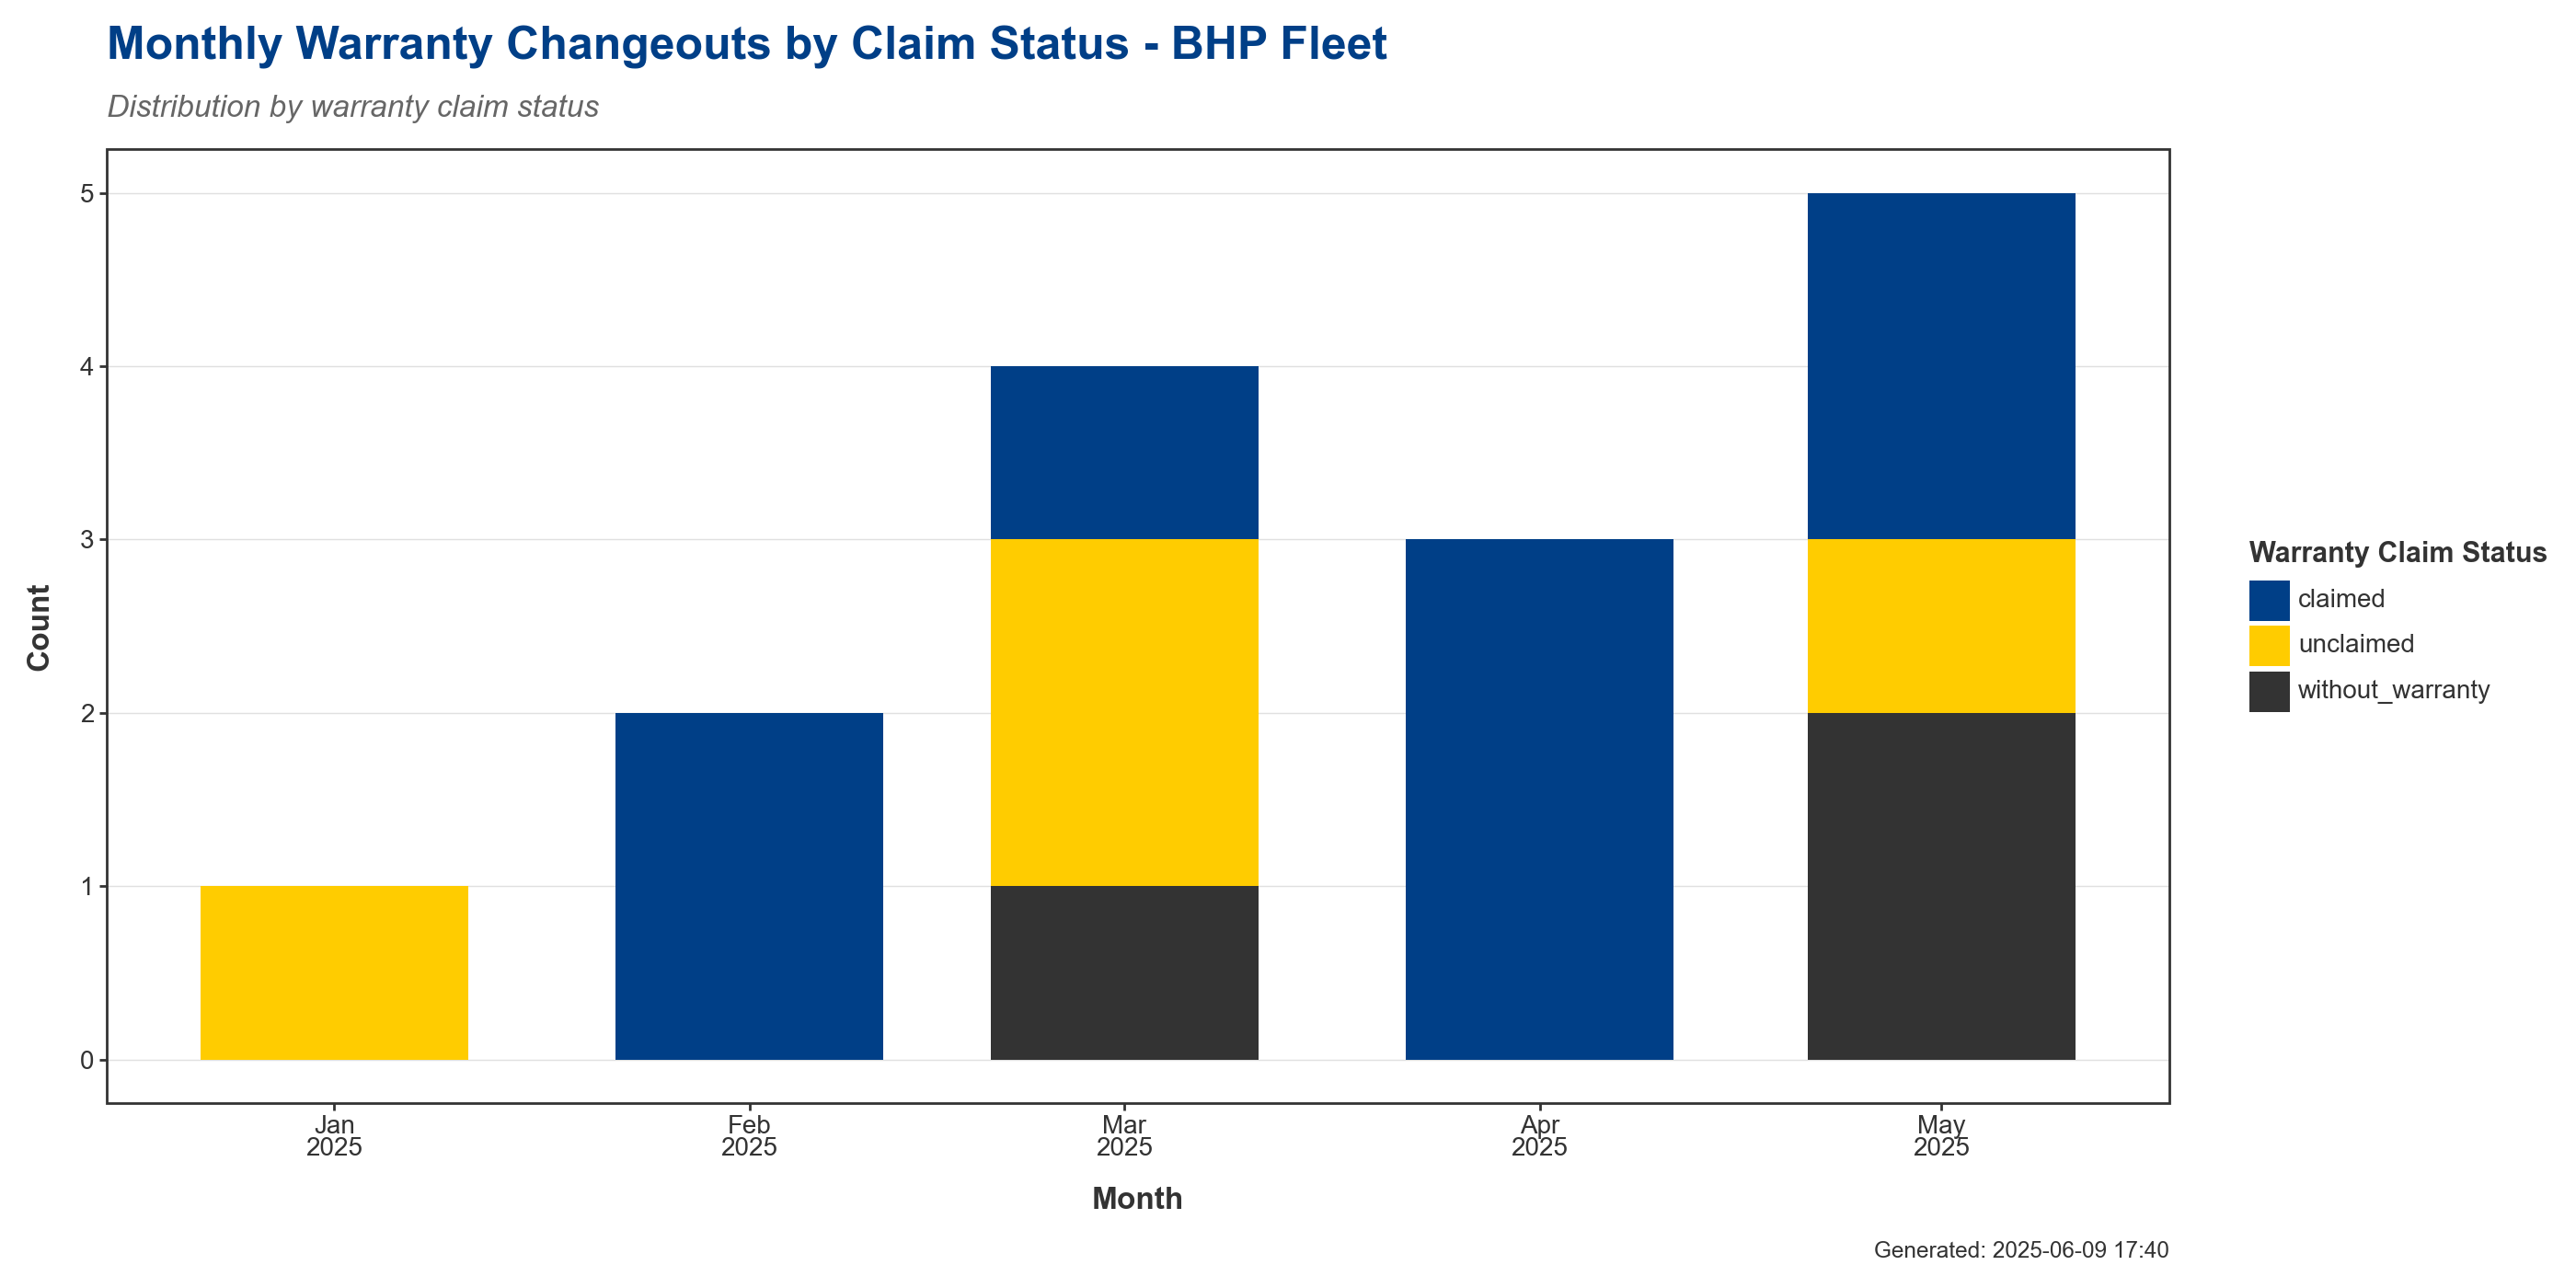

In [32]:
# Method 2: Use the main function with custom parameters
plot_data = prepare_monthly_data(
    w_df,
    date_column="changeout_date",
    group_column="warranty_claim_status",
    count_label="warranty_count",
)
# Then create your plot
plot = create_monthly_bar_plot(
    df_aggregated=plot_data,
    group_column="warranty_claim_status",
    title="Monthly Warranty Changeouts by Claim Status",
    title_suffix=" - BHP Fleet",
    show_all_months=True,
)
plot